# Prédire l'attrition des employés

**OBJECTIF :** Connaître les principales raisons d'attrition des employés et construire un modèle de réseau de neurounes performant pour faire des prédictions.

Le fichier ***data_dictionary*** contient toutes les informations sur les variables, expliquant les valeurs des variables et leur impact. L'attrition est la colonne cible. L'attrition désigne les employés qui ont quitté l'organisation. Nous devons découvrir quels facteurs / caractéristiques des données sont liés à l'attrition des employés.

Les données sont déséquilibrées. Le principal problème avec le déséquilibre est que le modèle ne comprend pas bien la classe minoritaire et tente de la classer comme classe majoritaire.
Dans ce projet, nous traiterons ce problème de déséquilibre et essayerons d'implémenter les différentes méthodes telles que le sous-échantillonnage, le sur-échantillonnage, SMOTE, ADSYN TomekLinks, afin de remedier à ce probleme. 

**Sommaire :**
  * 1. Importation des bibliothèques
  * 2. Importation des données
  * 3. Analyse exploratoire des données
    * 3.1. Analyse de la forme
    * 3.2. Analyse univariée
    * 3.3. Analyse bivariée
  * 4. Prétraitement des données
  * 5. Encodage des données
  * 6. Imputation des données manquantes
  * 7. Train validation test split
  * 8. Modelisation
    * 8.1. Méthodes d'évalusation 
    * 8.2. Estimation des hyperparamètres et construction d'un model élaboré
      * 8.2.1. Estimation des hyperparamètres "batch_size", "epochs" et "optimizer"
      * 8.2.2. Estimation du pas d'apprentissage "learning_rate"
      * 8.2.3. Estimation de la fonction d'activation des neurones
      * 8.2.4. Estimation de la régularisation des abandons
      * 8.2.5. Estimation du nombre de neuroune dans la couche cachée
    * 8.3. Entrainement simple du model 
    * 8.4. Entraînement avec pondêration des classes
    * 8.5. Entraînement avec oversampling
      * 8.5.1. Random oversampling
      * 8.5.2. SMOTE
      * 8.5.3. ADASYN
    * 8.6. Entraînement avec undersampling
      * 8.6.1. Random undersampling
      * 8.6.2. Tomek links
    * 8.7. Entraînement avec une approche hybrid de resampling
      * 8.7.1. Random oversampling + Tomek links
      * 8.7.2. SMOTE + Tomek links
  * 9. Conclusion


**Réalisé par :**
  - Yanis AIT HAMMOU
  - Sarah YAKOUBENE


## 1. Importation des bibliothèques

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import ttest_ind
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline
import os
import tempfile
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

## 2. Importation des données

In [ ]:
path = 'https://drive.google.com/uc?export=download&id=1AiygtahWdXDhNNzib0CgfMm475iQHjCE'

# Importation des données
data = pd.read_csv(path, sep=",", index_col=0, header=0)

# Afficher les 5 premieres lignes
data.head()

,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,3,3.0,4.0,2.0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
2,2,4,3.0,2.0,4.0,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
3,3,3,2.0,2.0,1.0,32,No,Travel_Frequently,Research & Development,17,4,Other,1,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
4,2,3,4.0,4.0,3.0,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
5,3,3,4.0,1.0,3.0,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


## 3. Analyse Exploratoire des données

### 3.1. Analyse de la forme

In [ ]:
# Supprimer er récuperer la variable target du dataframe
target = data.Attrition
data = data.drop(columns=["Attrition"])

# Afficher les dimension du dataframe
print(f"Dimensions : \n\tlignes : {data.shape[0]}\n\tcolonnes : {data.shape[1]}")

Dimensions : 
	lignes : 4410
	colonnes : 27


In [ ]:
# Afficher le nombre de valeurs manquantes, le type des variable et le nombre de valeurs uniques 
df = []
for col in data.columns:
    df.append([col, np.unique(data[col]).shape[0]])
df = pd.DataFrame(df, columns=["col", "# unique values"]).set_index("col")

pd.DataFrame(data.isna().sum()).rename(columns={0: "# missing values"}).join(pd.DataFrame(data.dtypes).rename(columns={0: "# column type"})).join(df)

,# missing values,# column type,# unique values
JobInvolvement,0,int64,4
PerformanceRating,0,int64,2
EnvironmentSatisfaction,25,float64,29
JobSatisfaction,20,float64,24
WorkLifeBalance,38,float64,42
Age,0,int64,43
BusinessTravel,0,object,3
Department,0,object,3
DistanceFromHome,0,int64,29
Education,0,int64,5


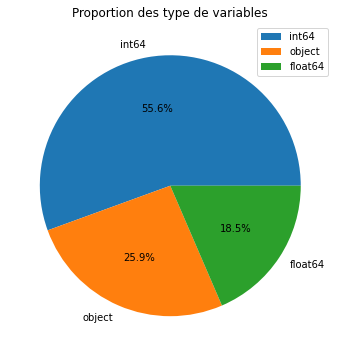

In [ ]:
# Afficher la proportion des types de variables
data.dtypes.value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Proportion des type de variables")
plt.legend()
plt.show()

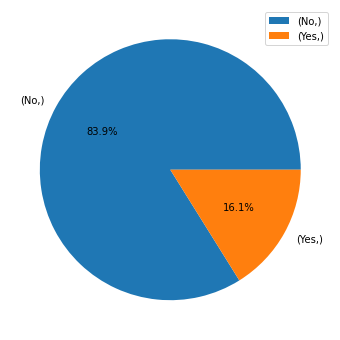

In [ ]:
# Visualisation de la variable target

# Afficher les proportion du nombre d'observation
pd.DataFrame(target).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="")
plt.legend()
plt.show()

### 3.2. Analyse univariée

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


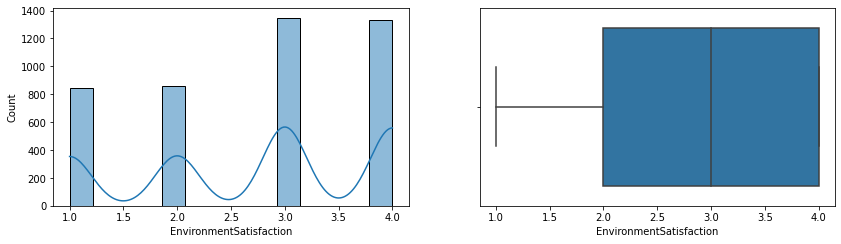

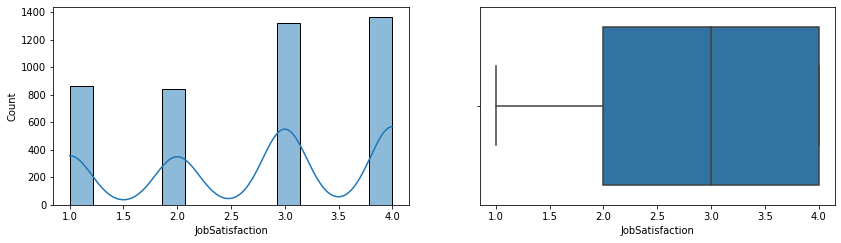

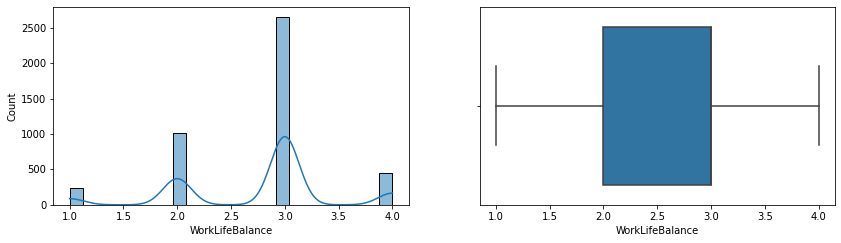

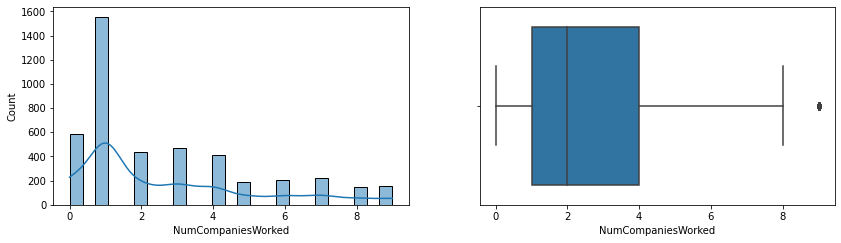

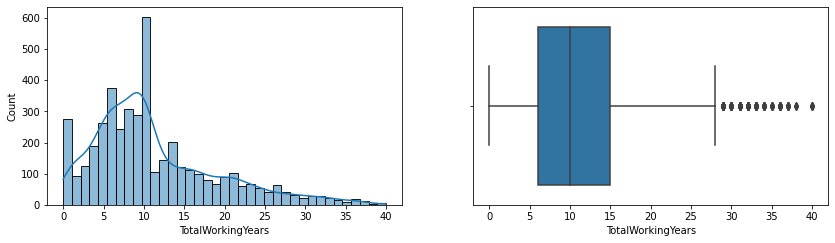

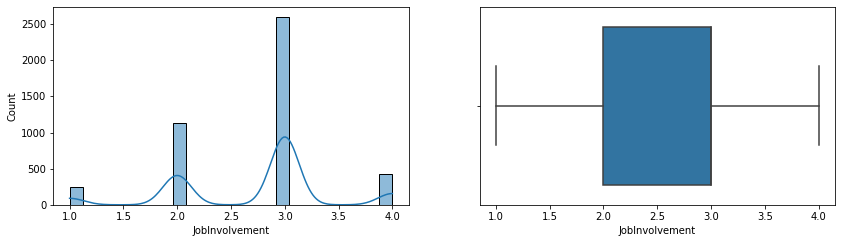

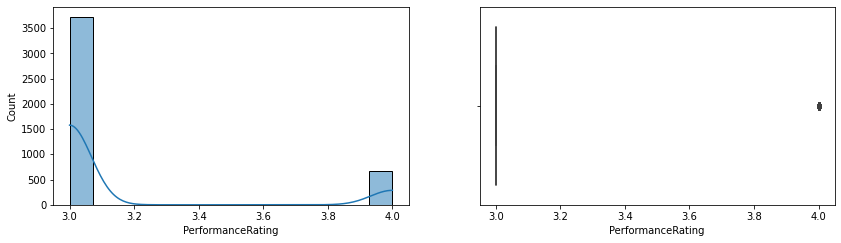

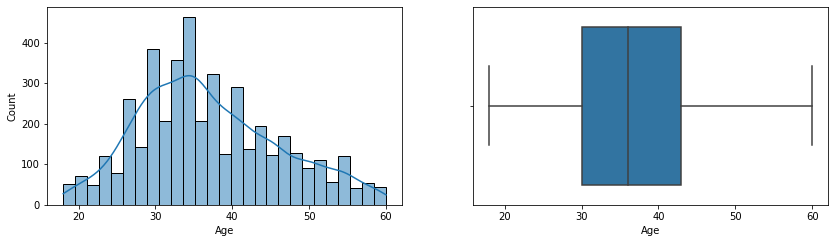

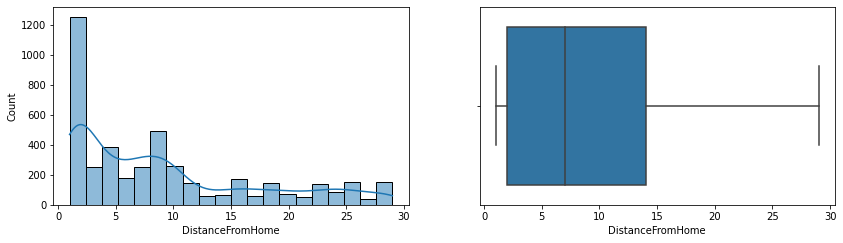

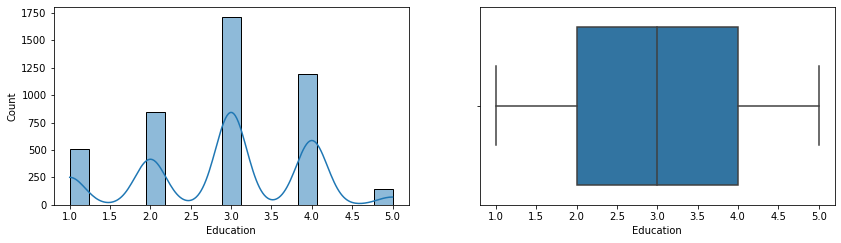

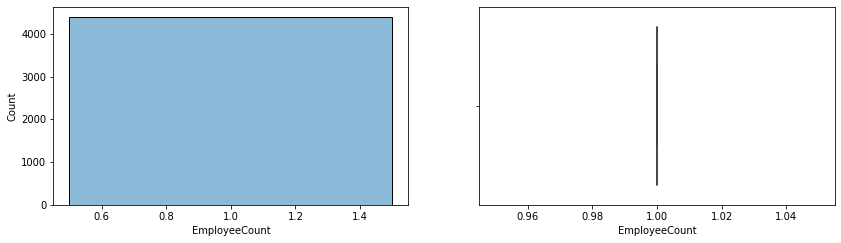

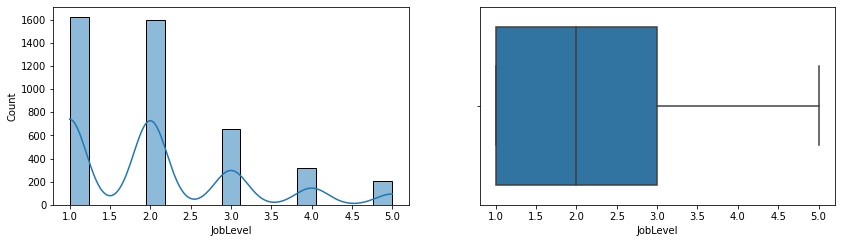

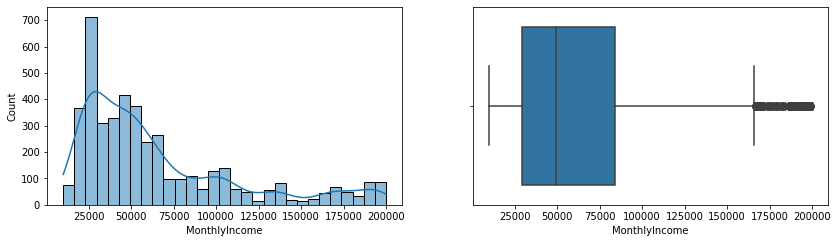

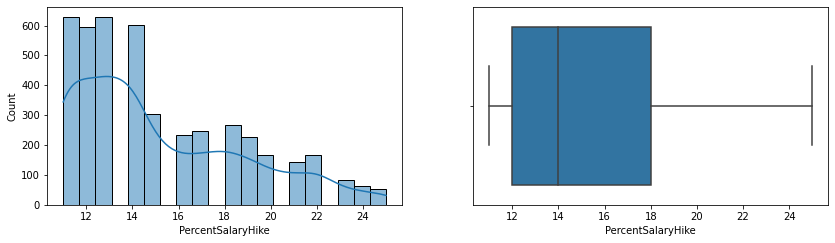

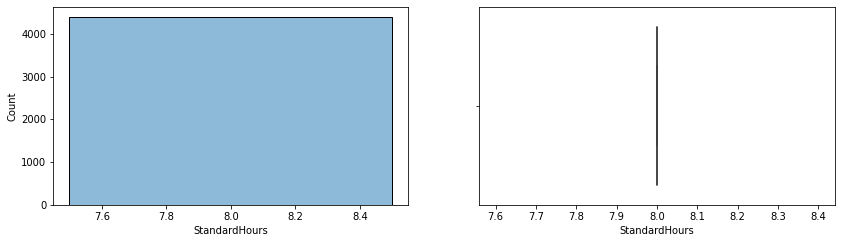

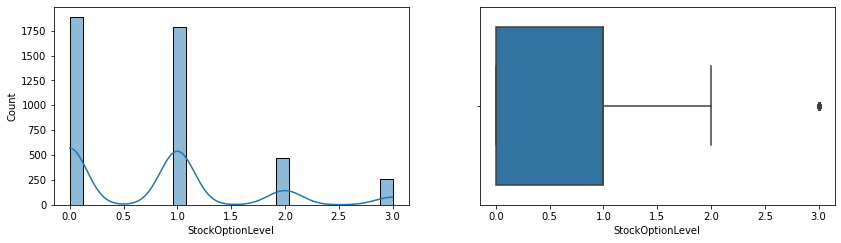

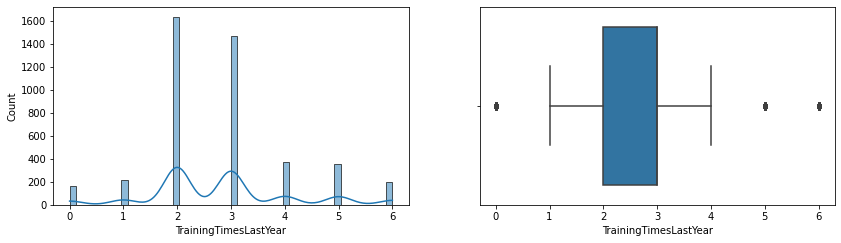

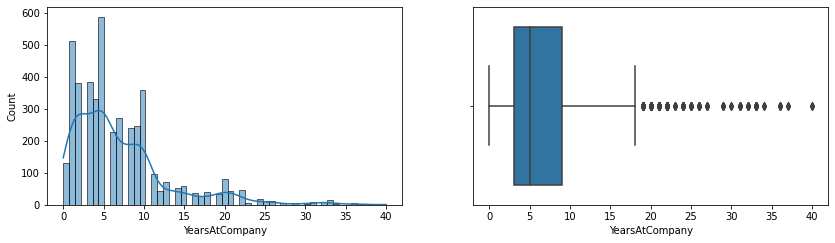

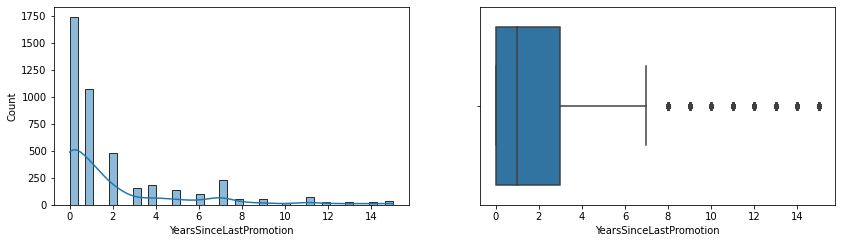

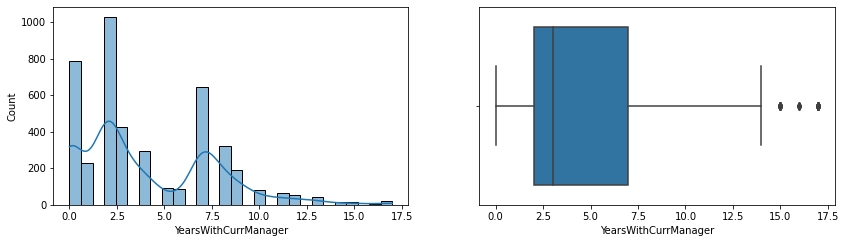

In [ ]:
# Variables Qauntitative
for col in  data.select_dtypes('float').join( data.select_dtypes('int64')):
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    sns.histplot(data[col], kde=True)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=data, x=col)
plt.show()

BusinessTravel------------------------------------ ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department---------------------------------------- ['Sales' 'Research & Development' 'Human Resources']
EducationField------------------------------------ ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender-------------------------------------------- ['Female' 'Male']
JobRole------------------------------------------- ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
MaritalStatus------------------------------------- ['Married' 'Single' 'Divorced']
Over18-------------------------------------------- ['Y']


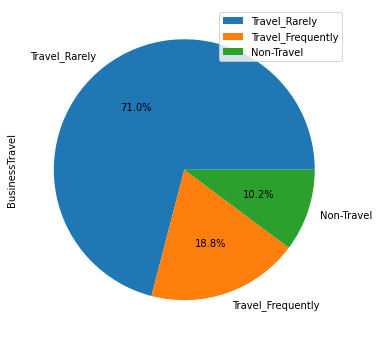

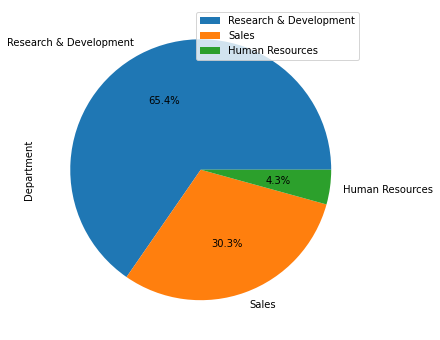

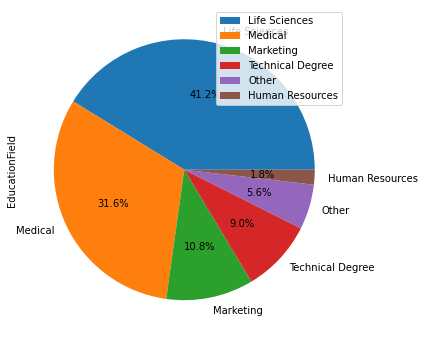

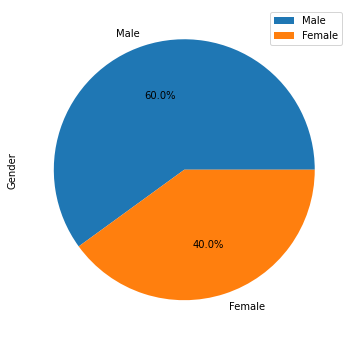

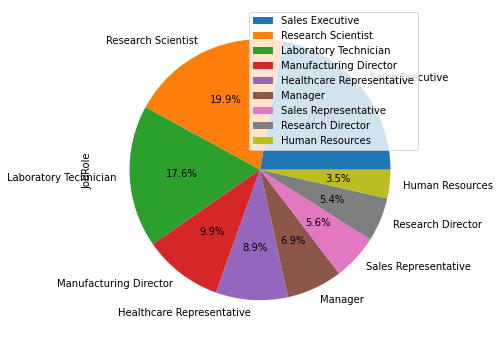

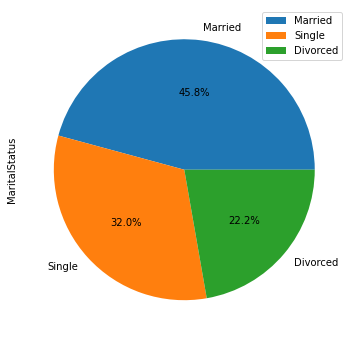

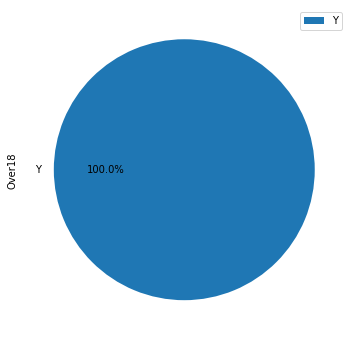

In [ ]:
# Variables Qualitatives
for col in data.select_dtypes('object'):
    print(f'{col :-<50} {data[col].unique()}')
    
    
for col in data.select_dtypes('object'):
    plt.figure()
    data[col].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), label=col)
    plt.legend()
    plt.show()

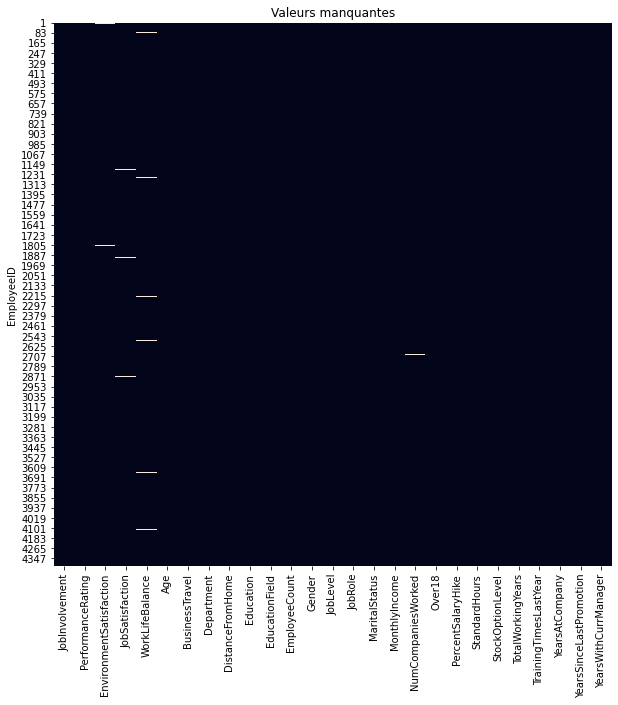

Valeurs manqunates:


JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [ ]:
# Visualisation des données manquantes

plt.figure(figsize=(10, 10))
sns.heatmap(data.isnull(), cbar=False)
plt.title("Valeurs manquantes")
plt.show()

print("Valeurs manqunates:")
data.isnull().sum()

### 3.2. Analyse bivariée

In [ ]:
data_yes = data[target == "Yes"]
data_no = data[target == "No"]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


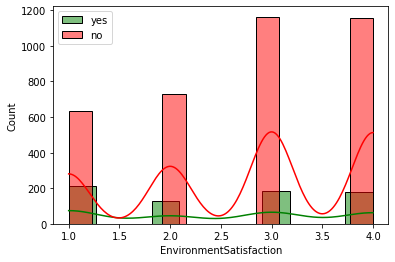

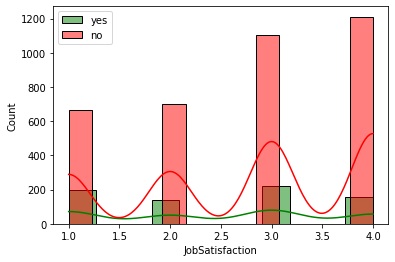

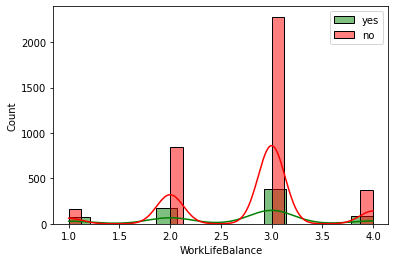

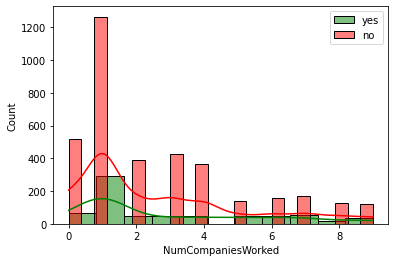

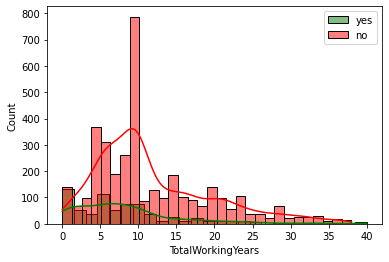

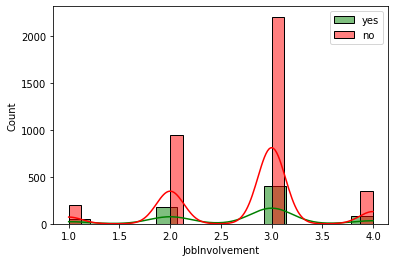

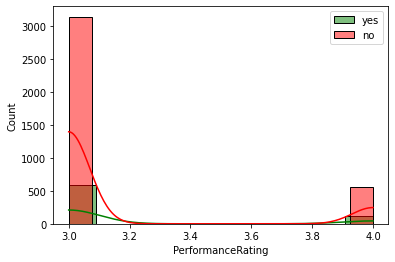

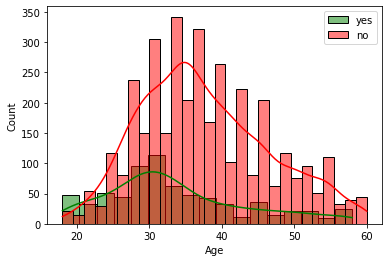

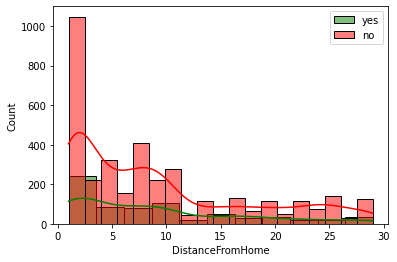

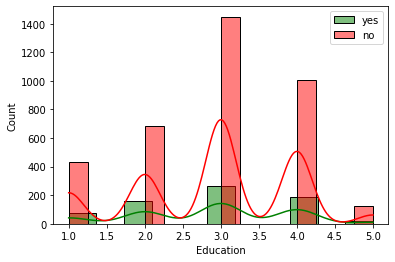

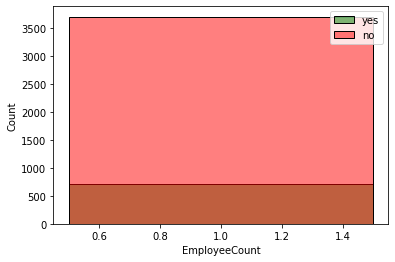

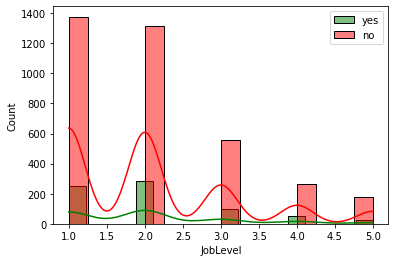

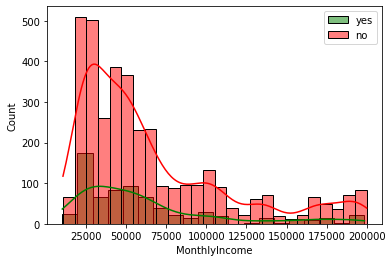

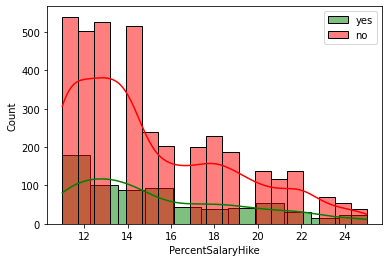

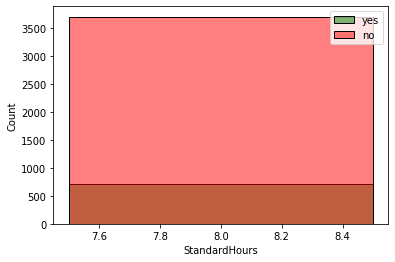

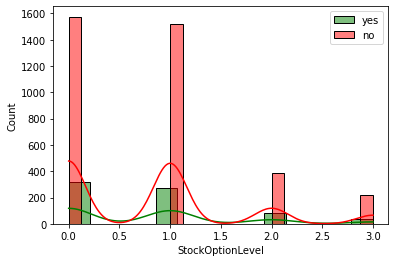

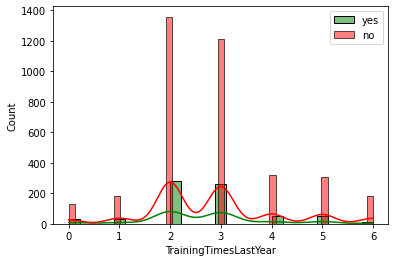

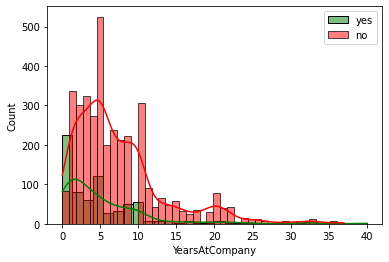

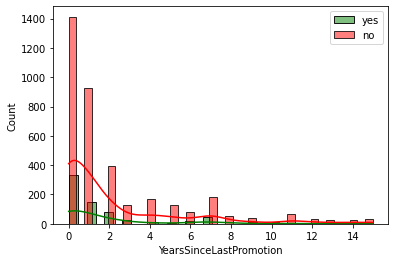

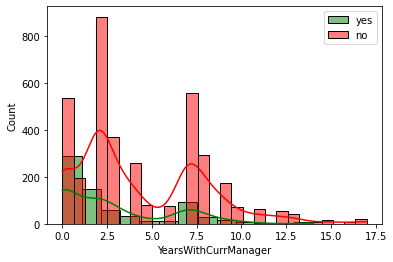

In [ ]:
for col in data.select_dtypes('float').join( data.select_dtypes('int64')):
    plt.figure()
    sns.histplot(data_yes[col], kde=True, label="yes", color="green")
    sns.histplot(data_no[col], kde=True, label="no", color="red")
    plt.legend()

## 4. Prétraitement des données

In [ ]:
def preprocessing():
    # Créer un copie du dataframe
    df = data.copy()
    return df

In [ ]:
# Appliquer la fonction de preprocessing sur les données de base
df = preprocessing()

# Afficher le dataframe
df.shape

(4410, 27)

## 5. Encodage des données

In [ ]:
## Encodage des données
class OrdinalEncoder:
    """
        Encode categorical features as a ordinal numeric dataframe.
    """
    def __init__(self,):
        self.new_columns = None
        
    def fit(self, X, y=None):
        self.columns = X.columns
        self.new_columns=pd.get_dummies(X, columns=self.columns).columns
        return self
    
    def transform(self, X, y=None):
        if self.new_columns is None :
            raise NotImplementedError()
        else :
            res = pd.get_dummies(X, columns=self.columns)
            for column in self.new_columns:
                if column not in res.columns:
                    res[column] = np.zeros(res.shape[0])
            return res[self.new_columns]
        
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

## 6. Imputation des données manquantes

In [ ]:
# Encoder les données avant de faire l'imputation 

# Localiser les colonnes à imputer
columns_to_imput = df.columns[df.isnull().sum() > 0]
print(f"les colonnes à imputer : \n\t{columns_to_imput}\n")

# Localiser les autres colonnes 
other_columns = df.columns[df.isnull().sum() == 0]
print(f"les autres colonnes : \n\t{other_columns}\n")

for column in columns_to_imput:
    
    index_nan_values = df.index[df[column].isnull()]
    
    values = pd.concat([df[column]], axis=0)

    values = values.astype("category").cat.codes

    df[column] = values.loc[df.index]
    
    df[column].loc[index_nan_values] = np.NAN

les colonnes à imputer : 
	Index(['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'NumCompaniesWorked', 'TotalWorkingYears'],
      dtype='object')

les autres colonnes : 
	Index(['JobInvolvement', 'PerformanceRating', 'Age', 'BusinessTravel',
       'Department', 'DistanceFromHome', 'Education', 'EducationField',
       'EmployeeCount', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus',
       'MonthlyIncome', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# Encoder les variable avant l'imputation
# Les variables qui ont le nombre de valeurs unique inferieur à 7 sont concederer comme des variables categorielles.

categorical_columns = ['JobInvolvement', 'PerformanceRating', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'EmployeeCount', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'Over18', 'StandardHours', 'StockOptionLevel', 'TrainingTimesLastYear']

numeric_columns = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

encoder = OrdinalEncoder().fit(df[categorical_columns]) 

df_encoded = pd.concat([df[numeric_columns], encoder.transform(df[categorical_columns]), df[columns_to_imput]], axis=1)

df_encoded

,Age,DistanceFromHome,MonthlyIncome,PercentSalaryHike,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,PerformanceRating_3,PerformanceRating_4,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EmployeeCount_1,Gender_Female,Gender_Male,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,StandardHours_8,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,TrainingTimesLastYear_0,TrainingTimesLastYear_1,TrainingTimesLastYear_2,TrainingTimesLastYear_3,TrainingTimesLastYear_4,TrainingTimesLastYear_5,TrainingTimesLastYear_6,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked,TotalWorkingYears
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,6,131160,11,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,2.0,3.0,1.0,1.0,1.0
2,31,10,41890,23,5,1,4,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,2.0,1.0,3.0,0.0,6.0
3,32,17,193280,15,5,0,3,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1.0,1.0,0.0,1.0,5.0
4,38,2,83210,11,8,7,5,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,3.0,3.0,2.0,3.0,13.0
5,32,10,23420,12,6,0,4,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,3.0,0.0,2.0,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,42,5,60290,17,3,0,2,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,3.0,0.0,2.0,3.0,10.0
4407,29,2,26790,15,3,0,2,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,3.0,3.0,2.0,2.0,10.0
4408,25,25,37020,20,4,1,2,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0.0,2.0,2.0,0.0,5.0


In [ ]:
# Define imputer
imputer = KNNImputer(n_neighbors=5)

# Fit on the dataset
imputer.fit(df_encoded)

# Estimer les valeurs manquantes
df_encoded_imputed = imputer.transform(df_encoded)

# Transformer le tableau en dataframe
df_encoded_imputed = pd.DataFrame(df_encoded_imputed, columns=df_encoded.columns, index=df_encoded.index)

# Afficher les nouvelles dimensions
print(f"Dimensions : \n\tlignes : {df_encoded_imputed.shape[0]}\n\tcolonnes : {df_encoded_imputed.shape[1]}")

# Afficher les premiers lignes du dataset
df_encoded_imputed

Dimensions : 
	lignes : 4410
	colonnes : 68


,Age,DistanceFromHome,MonthlyIncome,PercentSalaryHike,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,PerformanceRating_3,PerformanceRating_4,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EmployeeCount_1,Gender_Female,Gender_Male,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,StandardHours_8,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,TrainingTimesLastYear_0,TrainingTimesLastYear_1,TrainingTimesLastYear_2,TrainingTimesLastYear_3,TrainingTimesLastYear_4,TrainingTimesLastYear_5,TrainingTimesLastYear_6,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked,TotalWorkingYears
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51.0,6.0,131160.0,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0,1.0,1.0
2,31.0,10.0,41890.0,23.0,5.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,6.0
3,32.0,17.0,193280.0,15.0,5.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,5.0
4,38.0,2.0,83210.0,11.0,8.0,7.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,2.0,3.0,13.0
5,32.0,10.0,23420.0,12.0,6.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,42.0,5.0,60290.0,17.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,2.0,3.0,10.0
4407,29.0,2.0,26790.0,15.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0,10.0
4408,25.0,25.0,37020.0,20.0,4.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,5.0


In [ ]:
# Vérifier s'il ne reste pas de valeurs manquantes
df_encoded_imputed.isnull().sum().sum()

0

Dimensions : 
	lignes : 3892
	colonnes : 68


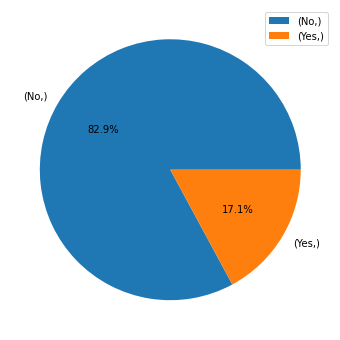

In [ ]:
## Suppression de valeurs abberantes 
def drop_outliers(df, field_name):
    distance = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)
    df.drop(df[df[field_name] < np.percentile(df[field_name], 25) - distance].index, inplace=True)


df_encoded_imputed_ = df_encoded_imputed.copy()
for colum in df_encoded_imputed_.columns:
  drop_outliers(df_encoded_imputed_, column)


# Afficher les nouvelles dimensions
print(f"Dimensions : \n\tlignes : {df_encoded_imputed_.shape[0]}\n\tcolonnes : {df_encoded_imputed_.shape[1]}")


# Afficher les nouvelles proportions du nombre d'observation
pd.DataFrame(target.loc[df_encoded_imputed_.index]).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="")
plt.legend()
plt.show()

In [ ]:
# Normalisation des données
minmax_scaler = MinMaxScaler().fit(df_encoded_imputed)
df_encoded_imputed_normalised = pd.DataFrame(minmax_scaler.transform(df_encoded_imputed),
                                             columns=df_encoded_imputed.columns,
                                             index=df_encoded_imputed.index)
df_encoded_imputed_normalised

,Age,DistanceFromHome,MonthlyIncome,PercentSalaryHike,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,PerformanceRating_3,PerformanceRating_4,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EmployeeCount_1,Gender_Female,Gender_Male,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,StandardHours_8,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,TrainingTimesLastYear_0,TrainingTimesLastYear_1,TrainingTimesLastYear_2,TrainingTimesLastYear_3,TrainingTimesLastYear_4,TrainingTimesLastYear_5,TrainingTimesLastYear_6,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked,TotalWorkingYears
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.785714,0.178571,0.637546,0.000000,0.025,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.000000,0.333333,0.111111,0.025641
2,0.309524,0.321429,0.167457,0.857143,0.125,0.066667,0.235294,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.333333,1.000000,0.000000,0.153846
3,0.333333,0.571429,0.964666,0.285714,0.125,0.000000,0.176471,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.000000,0.111111,0.128205
4,0.476190,0.035714,0.385045,0.000000,0.200,0.466667,0.294118,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.666667,0.333333,0.333333
5,0.333333,0.321429,0.070195,0.071429,0.150,0.000000,0.235294,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.666667,0.444444,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,0.571429,0.142857,0.264350,0.428571,0.075,0.000000,0.117647,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.000000,0.666667,0.333333,0.256410
4407,0.261905,0.035714,0.087941,0.285714,0.075,0.000000,0.117647,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [ ]:
# Encoder la variable "target"
y = LabelEncoder().fit_transform(target.loc[df_encoded_imputed.index])

## 7. Train validation test split

In [ ]:
def train_validation_test_split(X, y, test_size=0.2, validation_size=0.2, random_state=1997):
    
    np.random.seed(random_state)
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    
    train_size = int((1 - test_size - validation_size) * X.shape[0]) 
    validation_size = int(validation_size * X.shape[0]) 
    test_size = int(test_size * X.shape[0])
    
    X_train = X.iloc[index[:train_size], :]
    y_train = y[index[:train_size]]
    
    X_validation = X.iloc[index[train_size : train_size + validation_size], :]
    y_validation = y[index[train_size : train_size + validation_size]]
        
    X_test = X.iloc[index[train_size + validation_size :], :]
    y_test = y[index[train_size + validation_size :] ]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

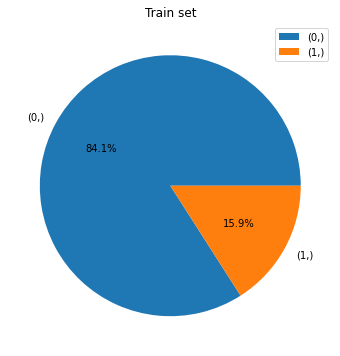

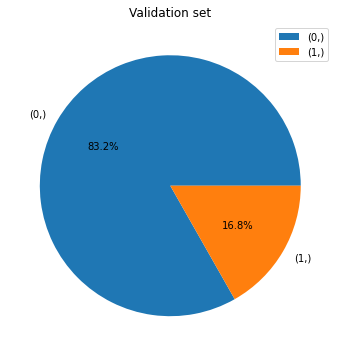

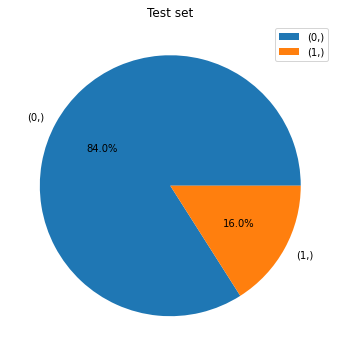

In [ ]:
 X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(df_encoded_imputed_normalised, y, test_size=0.2, validation_size=0.2)

# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_train).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()


# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_validation).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Validation set")
plt.legend()
plt.show()


# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_test).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Test set")
plt.legend()
plt.show()

# 8. Modelisation

## 8.1 Méthode d'évaludation

In [ ]:
# Definir la méthode d'evaluation du réseau de neuroune
auc_metrics = tf.keras.metrics.AUC(name="auc", curve="PR")


def auc_metric(estimator, X, y):
    
    y_pred = estimator.predict(X)
    
    # calculate sklearn AUC
    lr_precision, lr_recall, _ = precision_recall_curve(labels, pred_prob)
    pr_auc_score = auc(lr_recall, lr_precision)
    
    return pr_auc_score
    
# definir la fonction d'evaluatios robust et informative.
def evaluation(pred_prob, labels):
    
    # calculate sklearn AUC
    lr_precision, lr_recall, _ = precision_recall_curve(labels, pred_prob)
    pr_auc_score = auc(lr_recall, lr_precision)
    print(f"auc= { round(pr_auc_score, 2)}\n\n")
    
    # discretize the results
    pred = pred_prob.copy()
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # Classification report
    print(classification_report(labels, pred))

    # Calculate the confusion matrix
    cm = confusion_matrix(labels, pred)
    sns.heatmap(cm,  annot=True, fmt='d')
    plt.title("Matrice de confusion")
    plt.show()

    
# Afficher le auc et l'erreur durant l'entrainement du model.
def plot_training_history(history):
    acc = history['auc']
    val_acc = history['val_auc']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Auc')
    plt.plot(val_acc, label='Validation Auc')
    plt.legend(loc='lower right')
    plt.ylabel('auc')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Auc')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## 8.2 Estimation des hyperparamètres

Dans cette partie nous commencerons par estimer les hyperparamètres de notre réseau de neurones, avant d'appliquer les méthodes de "sous-échantillonnage" et de "suréchantillonnage" ect...

### 8.2.1. Estimation des hyperparametre "batch_size", "epochs" et "optimizer"

In [ ]:
# Definir la taille d'entrer de la couche cachée 
input_dim = X_train.shape[1]

In [ ]:
def create_model(optimizer='adam', learning_rate=0.001):

	# Creation du model
	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation='relu'))
	model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
	# Compiler le model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

	return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,  verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "batch_size" : [1, 2, 5, 10, 20, 40, 60, 80, 100],
    "epochs" : [10, 50, 100],
    "optimizer" : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

grid_result = grid.fit(X_train, y_train)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 189 candidates, totalling 567 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 99.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 114.6min
[Parallel(n_jobs=-1)]: Done 567 out of 567 | elapsed: 117.6min finished


Best: 0.917611 using {'batch_size': 1, 'epochs': 100, 'optimizer': 'Nadam'}


### 8.2.2. Estimation de l'hyperparametre "learning_rate"

In [ ]:
# Definir les hyperparametres precedement estimés
epochs = 100
batch_size = 1

In [ ]:
def create_model(learning_rate=0.001):

  # Creation du model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # definir l'optimizer
  optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate, name="Nadam")

  # Compiler le model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "learning_rate" : [0.01, 0.001, 0.0001, 0.00001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

grid_result = grid.fit(X_train, y_train)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 19.3min finished


Best: 0.923280 using {'learning_rate': 0.001}


### 8.2.3. Estimation de la fonction d'activation des neurones

In [ ]:
# Definir les hyperparametres precedement estimés
epochs = 100
batch_size = 1

In [ ]:
def create_model(activation="relu"):

  # Creation du model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation=activation))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # definir l'optimizer
  optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, name="Nadam")

  # Compiler le model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "activation" : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

grid_result = grid.fit(X_train, y_train)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 47.7min finished


Best: 0.923658 using {'activation': 'tanh'}


### 8.2.4. Estimation de la régularisation des abandons

In [ ]:
# Definir les hyperparametres precedement estimés
epochs = 100
batch_size = 1

In [ ]:
def create_model(dropout_rate=0.0):

  # Creation du model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation="tanh"))
  model.add(tf.keras.layers.Dropout(dropout_rate))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  # definir l'optimizer
  optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, name="Nadam")

  # Compiler le model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "dropout_rate" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

grid_result = grid.fit(X_train, y_train)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 61.5min finished


Best: 0.918367 using {'dropout_rate': 0.1}


### 8.2.5. Estimation du nombre de neuroune dans la couche cachée

In [ ]:
def create_model(neurons=1):

  # Creation du model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(neurons, input_dim=input_dim, activation="tanh"))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # definir l'optimizer
  optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, name="Nadam")

  # Compiler le model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "neurons" : [1, 5, 10, 15, 20, 25, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

grid_result = grid.fit(X_train, y_train)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 42.6min finished


Best: 0.931973 using {'neurons': 30}


In [ ]:
# Définir la fonction, pour construire le modèle de base
def create_baseline_model():

	# Creation du model
	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation='relu'))
	model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
	# Compiler le model
	model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[auc_metrics])

	return model

  
# Définir la fonction, pour construire le modèle adapté
def create_elaborate_model():

  # Creation du model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(30, input_dim=input_dim, activation="tanh"))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # definir l'optimizer
  optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, name="Nadam")

  # Compiler le model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[auc_metrics])

  return model

## 8.3. Entraînement simple

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.4142 - auc: 0.8820
AUC: 88.20


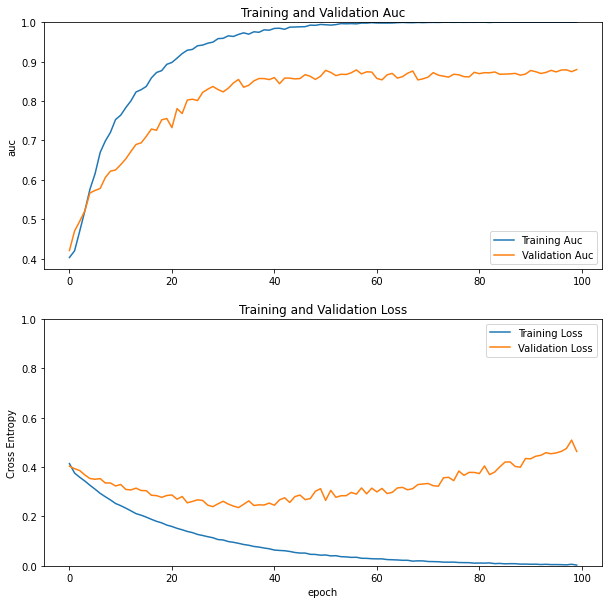

auc= 0.87


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       741
           1       0.93      0.90      0.91       141

    accuracy                           0.97       882
   macro avg       0.95      0.94      0.95       882
weighted avg       0.97      0.97      0.97       882



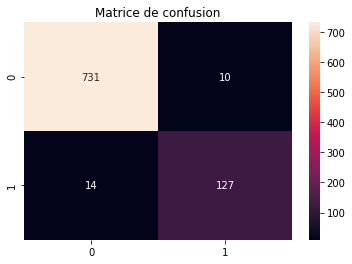


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.1461 - auc: 0.9470
AUC: 94.70


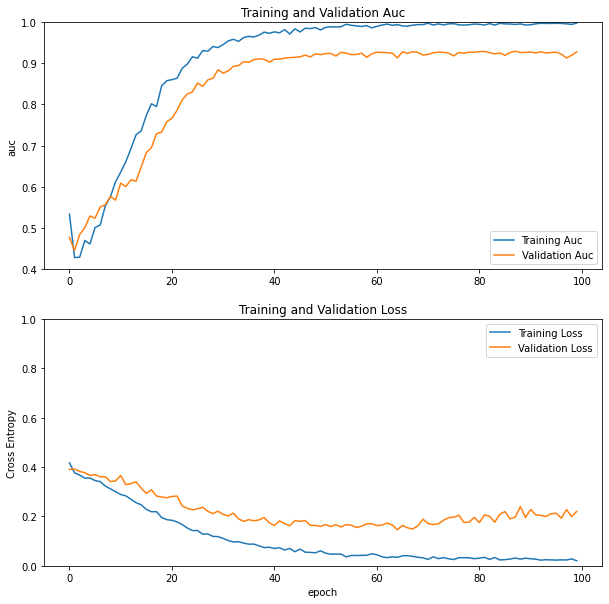

auc= 0.95


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       741
           1       0.98      0.89      0.93       141

    accuracy                           0.98       882
   macro avg       0.98      0.94      0.96       882
weighted avg       0.98      0.98      0.98       882



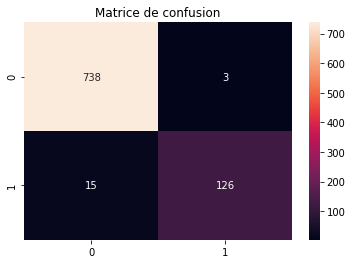

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 8.4. Entraînement avec pondération des classes


In [ ]:
# Définir la fonction pour calculer le poid de chaque classe 
def count_class_weight(data_labels):
    max_val = max((data_labels == 0).sum(), (data_labels == 1).sum())  
    class_weight = {
        0: round(max_val/(data_labels == 0).sum(), 2),
        1: round(max_val/(data_labels == 1).sum(), 2)
    }
    return class_weight

In [ ]:
# Calculer le de chaque classe 
class_weight = count_class_weight(y_train)
class_weight

{0: 1.0, 1: 5.27}

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.3183 - auc: 0.8588
AUC: 85.88


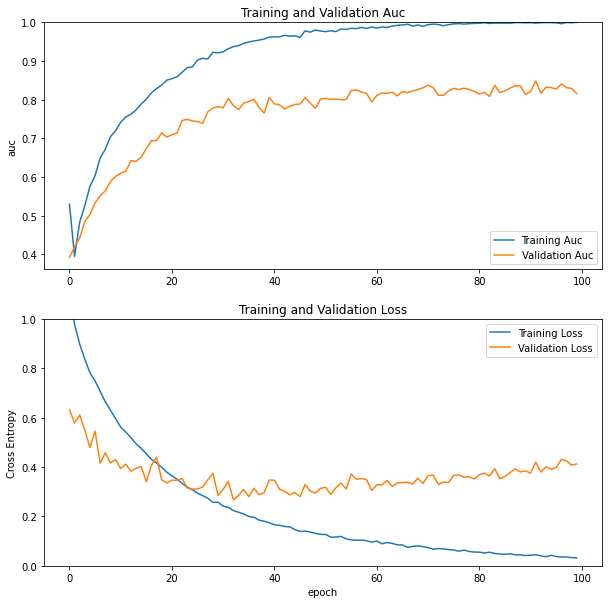

auc= 0.85


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       741
           1       0.86      0.90      0.88       141

    accuracy                           0.96       882
   macro avg       0.92      0.94      0.93       882
weighted avg       0.96      0.96      0.96       882



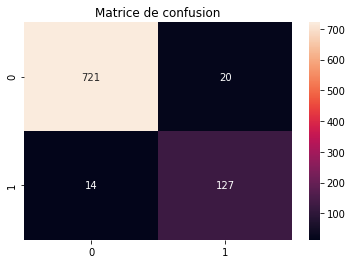


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.1672 - auc: 0.9097
AUC: 90.97


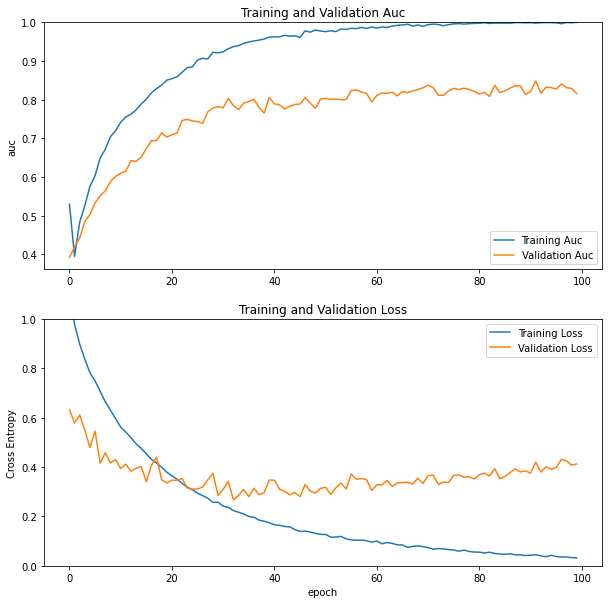

auc= 0.92


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       741
           1       0.98      0.86      0.91       141

    accuracy                           0.97       882
   macro avg       0.97      0.93      0.95       882
weighted avg       0.97      0.97      0.97       882



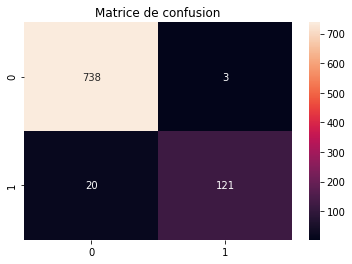

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_1_b= baseline_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, class_weight=class_weight, verbose=0)
print("\nelaborate model fit")
history_1_e= elaborate_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, class_weight=class_weight, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_1_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_1_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 8.5. Entraînement avec oversampling

### 8.5.1. Random oversampling

le suréchantillonnage est une façon de résoudre ce problème est de suréchantillonner les exemples dans la classe minoritaire. Cela peut être réalisé en dupliquant simplement des exemples de la classe minoritaire dans l'ensemble de données d'apprentissage avant d'ajuster un modèle. Cela peut équilibrer la distribution des classes mais ne fournit aucune information supplémentaire au modèle.

In [ ]:
# Definir la fonction
def sampling(X, y, sampling_strategy=None, shuffle=True, random_state=1997):
    
    if random_state is not None:
        np.random.seed(random_state)
        
    index_classe_0 = np.arange(y.shape[0])[y == 0]
    index_classe_1 = np.arange(y.shape[0])[y == 1]
    
    if sampling_strategy is None:
        if index_classe_0.shape > index_classe_1.shape[0]:
            index_classe_1 = np.random.choice(index_classe_1, p=np.ones(index_classe_1.shape[0])/index_classe_1.shape[0], replace=True, size=index_classe_0.shape[0])
        else:
            index_classe_0 = np.random.choice(index_classe_0, p=np.ones(index_classe_0.shape[0])/index_classe_0.shape[0], replace=True, size=index_classe_1.shape[0])
    else:
        index_classe_1 = np.random.choice(index_classe_1, p=np.ones(index_classe_1.shape[0])/index_classe_1.shape[0], replace=True, size=sampling_strategy[1])
        index_classe_0 = np.random.choice(index_classe_0, p=np.ones(index_classe_0.shape[0])/index_classe_0.shape[0], replace=True, size=sampling_strategy[0])

    X, y = pd.concat([X.iloc[index_classe_0], X.iloc[index_classe_1]], axis=0), np.array([0]*sampling_strategy[0] + [1]*sampling_strategy[1])
    
    if shuffle:
        index = np.arange(X.shape[0])
        np.random.shuffle(index)
        return X.iloc[index], y[index]
    
    return X, y

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([2224,  422]))

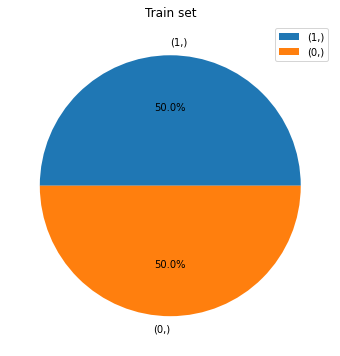

(array([0, 1]), array([2224, 2224]))

In [ ]:
over_strategy = {0:2224, 1:2224}
X_train_over, y_train_over =  sampling(X_train, y_train, sampling_strategy=over_strategy, random_state=1997)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_over).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_over, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.8197 - auc: 0.7091
AUC: 70.91


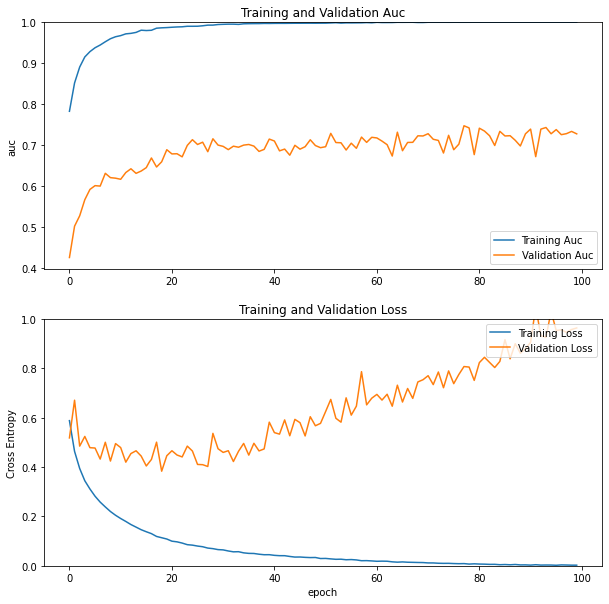

auc= 0.73


              precision    recall  f1-score   support

           0       0.97      0.92      0.95       741
           1       0.68      0.87      0.76       141

    accuracy                           0.91       882
   macro avg       0.83      0.90      0.86       882
weighted avg       0.93      0.91      0.92       882



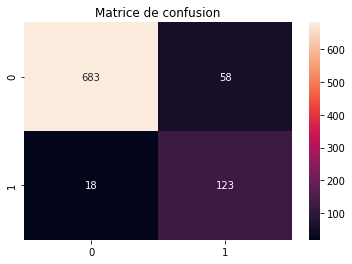


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.3135 - auc: 0.8724
AUC: 87.24


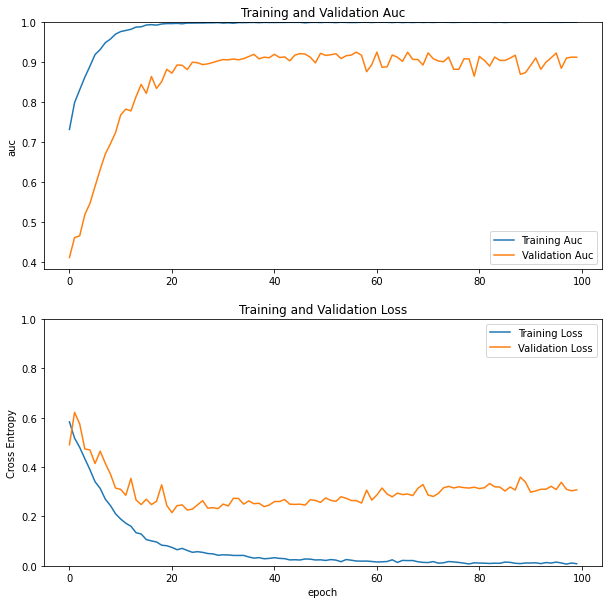

auc= 0.91


              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.79      0.92      0.85       141

    accuracy                           0.95       882
   macro avg       0.89      0.94      0.91       882
weighted avg       0.95      0.95      0.95       882



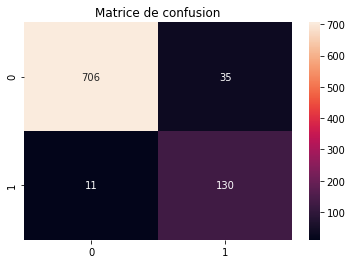

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_over, y_train_over, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_over, y_train_over, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 8.5.2. SMOTE
SMOTE fonctionne en sélectionnant des exemples qui sont proches dans l'espace des variables, en traçant une ligne entre les exemples dans l'espace des fonctionnalités et en dessinant un nouvel échantillon en un point le long de cette ligne.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


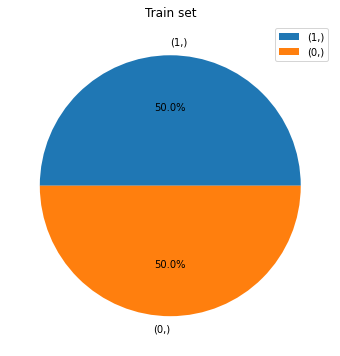

(array([0, 1]), array([2224, 2224]))

In [ ]:
smote_strategy = {0:2224, 1:2224 }
X_train_smote, y_train_smote =  SMOTE(sampling_strategy=smote_strategy, random_state=1997).fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_smote).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_smote, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.5395 - auc: 0.8621
AUC: 86.21


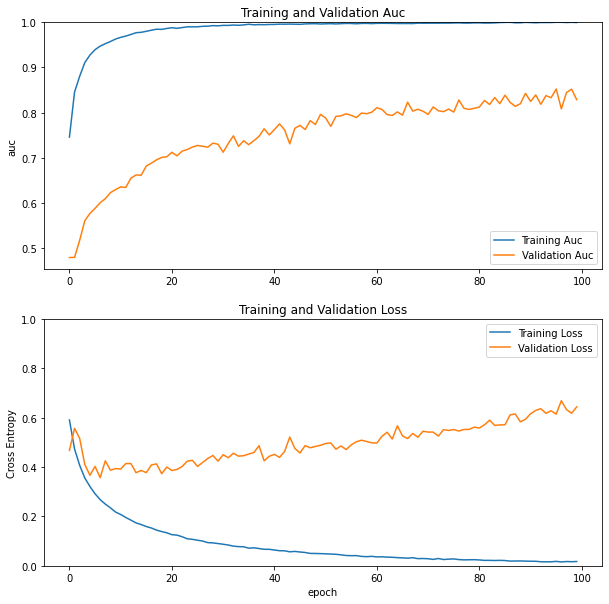

auc= 0.83


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       741
           1       0.82      0.91      0.86       141

    accuracy                           0.95       882
   macro avg       0.90      0.94      0.92       882
weighted avg       0.96      0.95      0.95       882



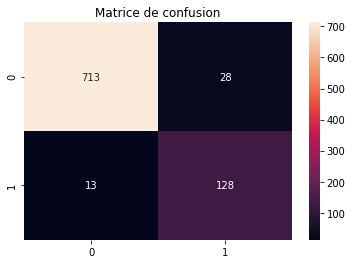


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.2315 - auc: 0.8899
AUC: 88.99


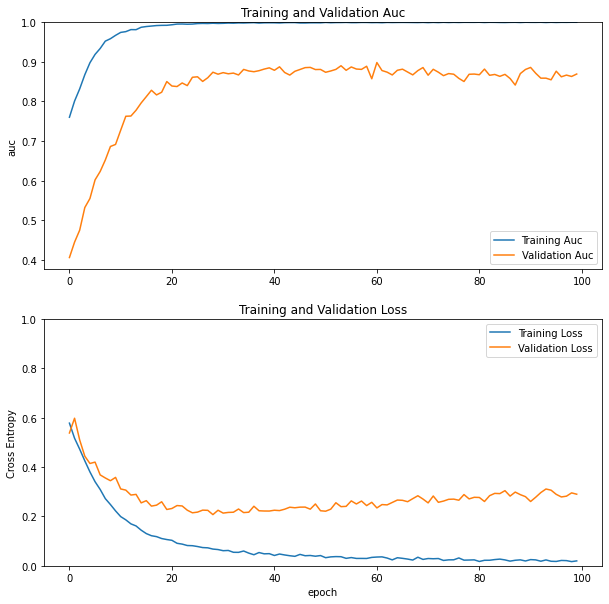

auc= 0.92


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       741
           1       0.93      0.88      0.91       141

    accuracy                           0.97       882
   macro avg       0.95      0.93      0.94       882
weighted avg       0.97      0.97      0.97       882



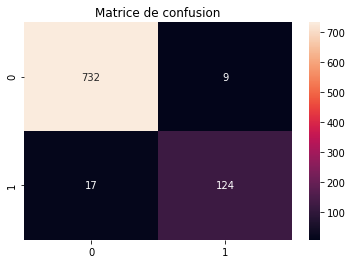

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_smote, y_train_smote , validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_smote, y_train_smote , validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 8.5.3. ADASYN

Une autre approche consiste à générer des échantillons synthétiques inversement proportionnels à la densité des exemples dans la classe minoritaire.

C'est-à-dire, générer des exemples plus synthétiques dans les régions de l'espace des caractéristiques où la densité des exemples minoritaires est faible, et moins ou aucun où la densité est élevée.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


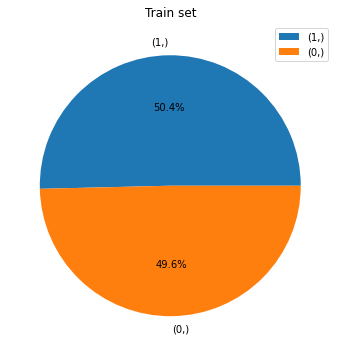

(array([0, 1]), array([2224, 2258]))

In [ ]:
adasyn_strategy = {0:2224, 1:2224 }
X_train_adasyn, y_train_adasyn =  ADASYN(sampling_strategy=adasyn_strategy, random_state=1997).fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_adasyn).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_adasyn, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.4399 - auc: 0.8742
AUC: 87.42


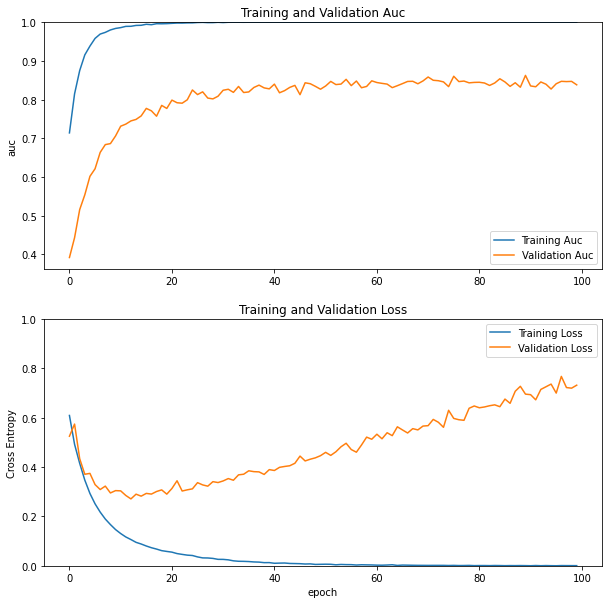

auc= 0.89


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       741
           1       0.87      0.94      0.90       141

    accuracy                           0.97       882
   macro avg       0.93      0.96      0.94       882
weighted avg       0.97      0.97      0.97       882



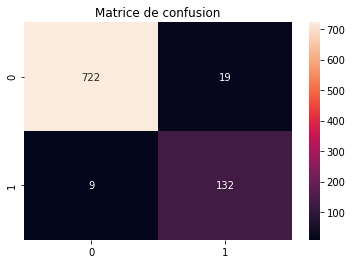


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.2293 - auc: 0.9381
AUC: 93.81


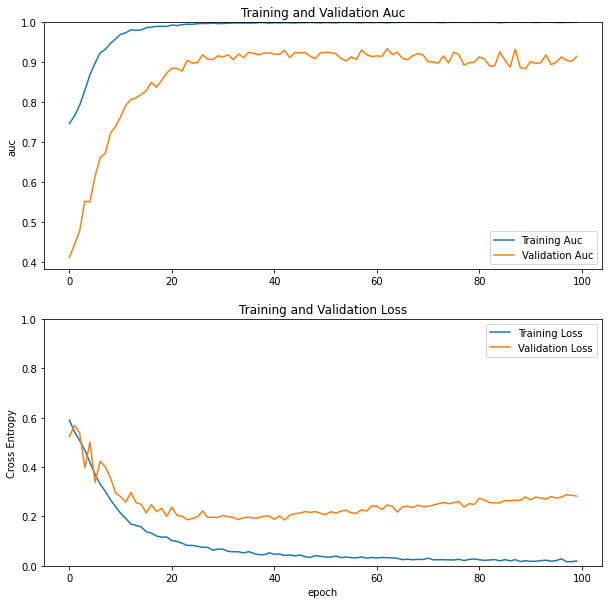

auc= 0.94


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       741
           1       0.89      0.89      0.89       141

    accuracy                           0.96       882
   macro avg       0.93      0.94      0.93       882
weighted avg       0.96      0.96      0.96       882



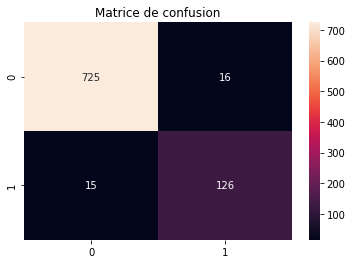

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_adasyn, y_train_adasyn, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_adasyn, y_train_adasyn, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 8.6. Entraînement avec undersampling


### 8.6.1. Random undersampling
cette technique consiste à retirez au hasard les échantillons de la classe majoritaire, avec ou sans remplacement.

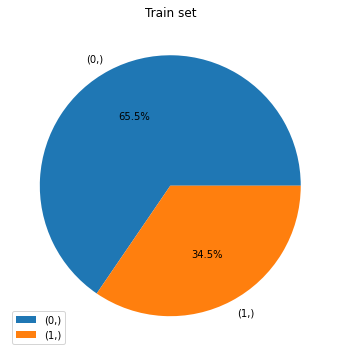

(array([0, 1]), array([800, 422]))

In [ ]:
under_strategy = {0:800, 1:422}
X_train_under, y_train_under =  sampling(X_train, y_train, sampling_strategy=under_strategy, random_state=1997)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_under).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_under, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 1.2120 - auc: 0.5823
AUC: 58.23


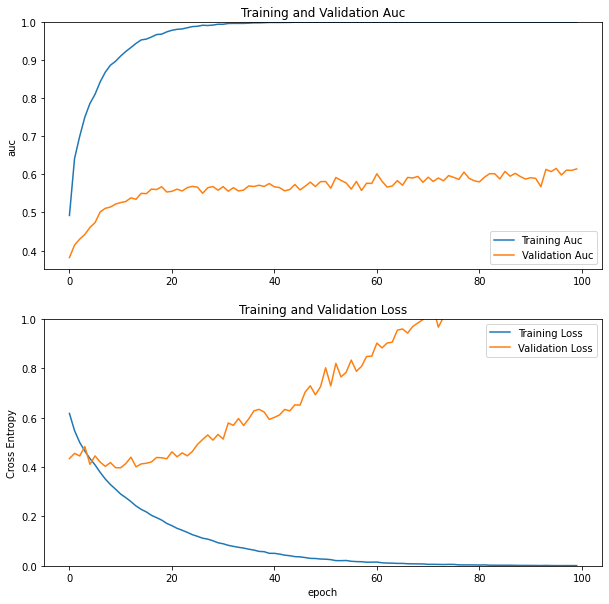

auc= 0.61


              precision    recall  f1-score   support

           0       0.95      0.89      0.92       741
           1       0.57      0.77      0.66       141

    accuracy                           0.87       882
   macro avg       0.76      0.83      0.79       882
weighted avg       0.89      0.87      0.88       882



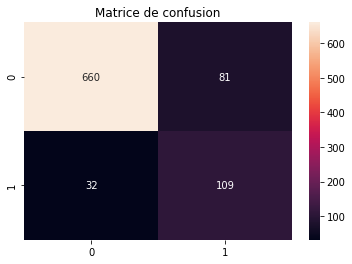


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.6807 - auc: 0.6278
AUC: 62.78


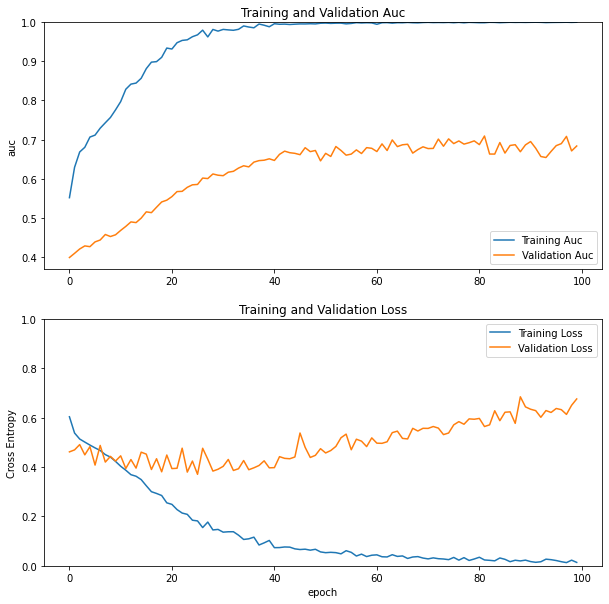

auc= 0.65


              precision    recall  f1-score   support

           0       0.96      0.89      0.92       741
           1       0.58      0.78      0.66       141

    accuracy                           0.87       882
   macro avg       0.77      0.84      0.79       882
weighted avg       0.89      0.87      0.88       882



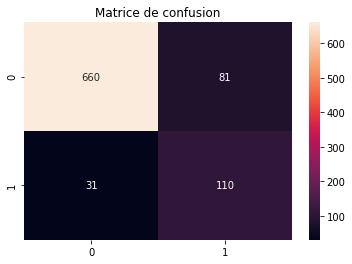

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_under, y_train_under, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_under, y_train_under, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 8.6.2. Tomek links

Cette technique onsiste à supprimer les observations de la classe majoritaire chevauchant celles de la classe minoritaire jusqu'à ce que toutes les paires de voisins les plus proches à une distance minimale soient de la même classe.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


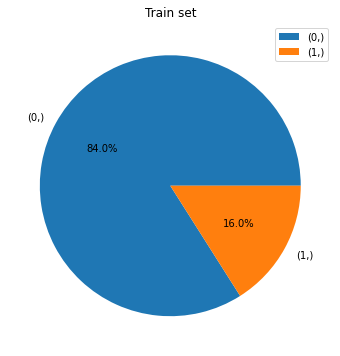

(array([0, 1]), array([2214,  422]))

In [ ]:
X_train_tomek, y_train_tomek = TomekLinks(n_jobs=-1).fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_tomek).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_tomek, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.2781 - auc: 0.8066
AUC: 80.66


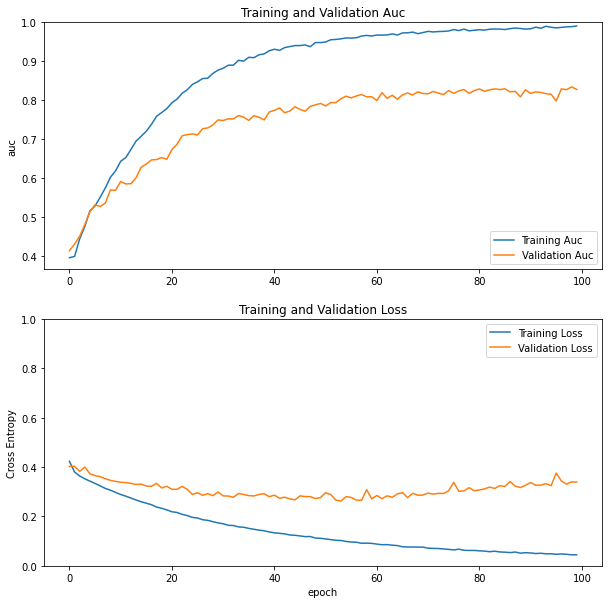

auc= 0.82


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       741
           1       0.81      0.82      0.81       141

    accuracy                           0.94       882
   macro avg       0.89      0.89      0.89       882
weighted avg       0.94      0.94      0.94       882



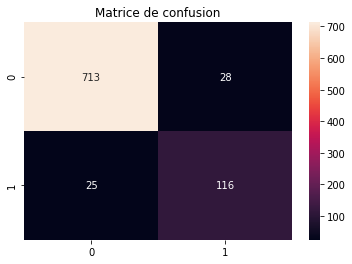


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.1723 - auc: 0.9468
AUC: 94.68


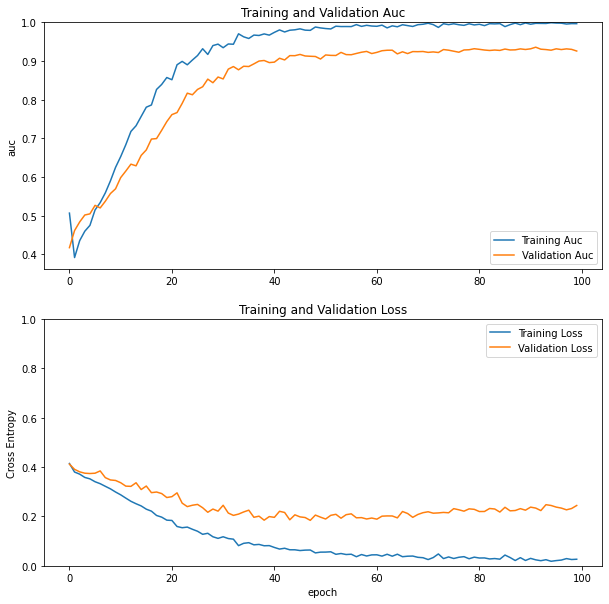

auc= 0.95


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       741
           1       0.93      0.89      0.91       141

    accuracy                           0.97       882
   macro avg       0.95      0.94      0.94       882
weighted avg       0.97      0.97      0.97       882



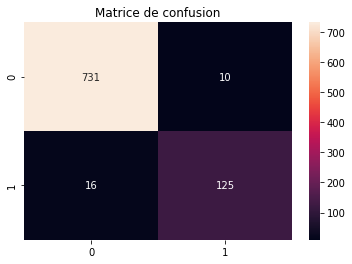

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_tomek, y_train_tomek, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_tomek, y_train_tomek, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 8.7. Entraînement avec une approche hybrid de resampling

### 8.7.1. Random oversampling + Tomek links

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


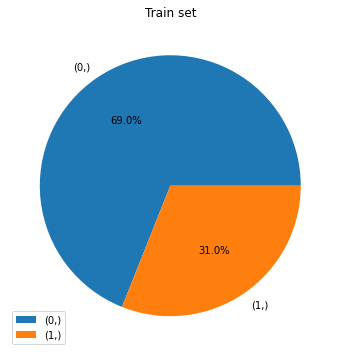

(array([0, 1]), array([2222, 1000]))

In [ ]:
over_strategy = {0:2224, 1:1000 }

X_train_over, y_train_over =  sampling(X_train, y_train, sampling_strategy=over_strategy, random_state=1997)

X_train_over_tomek, y_train_over_tomek = TomekLinks(n_jobs=-1).fit_resample(X_train_over, y_train_over)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_over_tomek).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_over_tomek, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.7713 - auc: 0.7883
AUC: 78.83


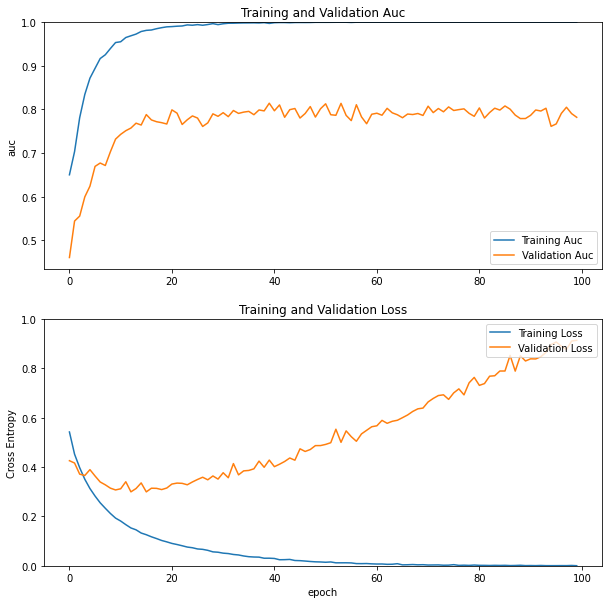

auc= 0.76


              precision    recall  f1-score   support

           0       0.98      0.95      0.96       741
           1       0.77      0.89      0.82       141

    accuracy                           0.94       882
   macro avg       0.87      0.92      0.89       882
weighted avg       0.94      0.94      0.94       882



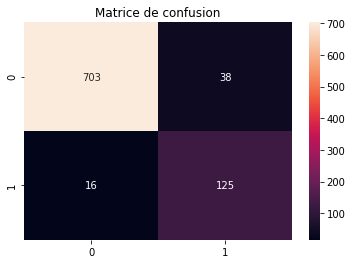


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.3652 - auc: 0.8433
AUC: 84.33


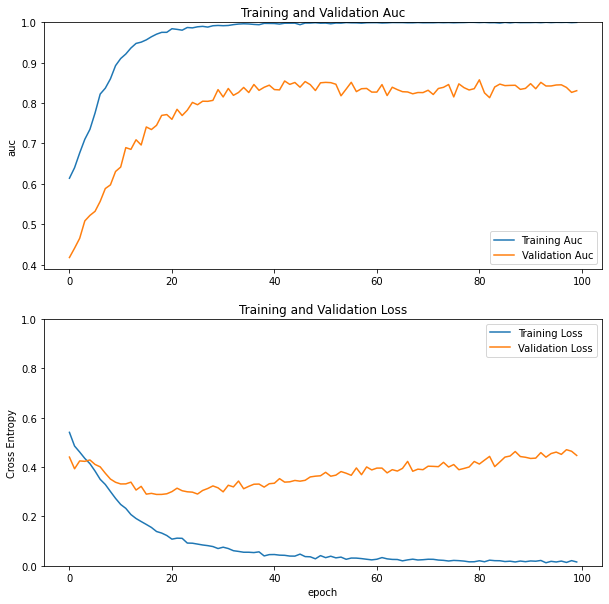

auc= 0.87


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       741
           1       0.81      0.85      0.83       141

    accuracy                           0.94       882
   macro avg       0.89      0.91      0.90       882
weighted avg       0.94      0.94      0.94       882



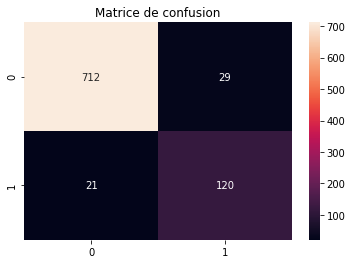

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_over_tomek, y_train_over_tomek , validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_over_tomek, y_train_over_tomek , validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 8.7.2. SMOTE + Tomek links

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


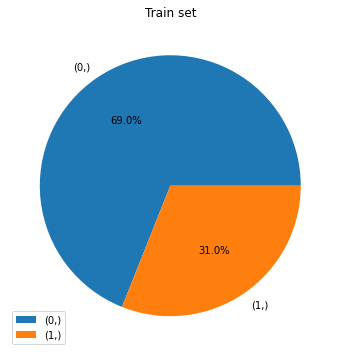

(array([0, 1]), array([2222, 1000]))

In [ ]:
smote_strategy = {0:2224, 1:1000 }
smote = SMOTE(sampling_strategy=smote_strategy, random_state=1997)

tomek = TomekLinks(n_jobs=-1)

steps = [('smote', smote), ("tomek", tomek)]
pipeline_over_tomek = Pipeline(steps=steps)


X_train_smote_tomek, y_train_smote_tomek = pipeline_over_tomek.fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_smote_tomek).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_smote_tomek, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.2884 - auc: 0.8489
AUC: 84.89


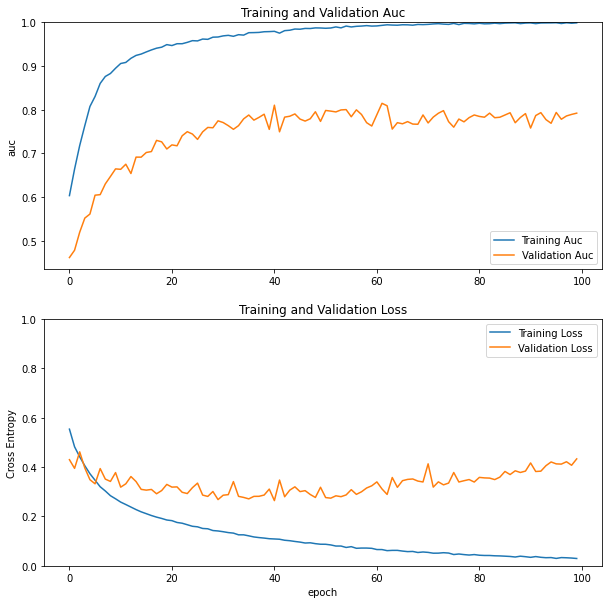

auc= 0.86


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       741
           1       0.83      0.89      0.86       141

    accuracy                           0.95       882
   macro avg       0.90      0.93      0.91       882
weighted avg       0.95      0.95      0.95       882



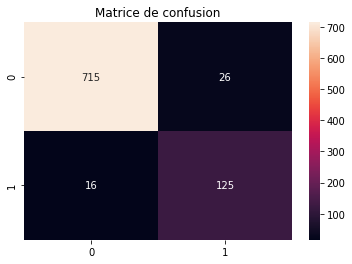


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

28/28 [==============================] - 0s 2ms/step - loss: 0.1818 - auc: 0.9528
AUC: 95.28


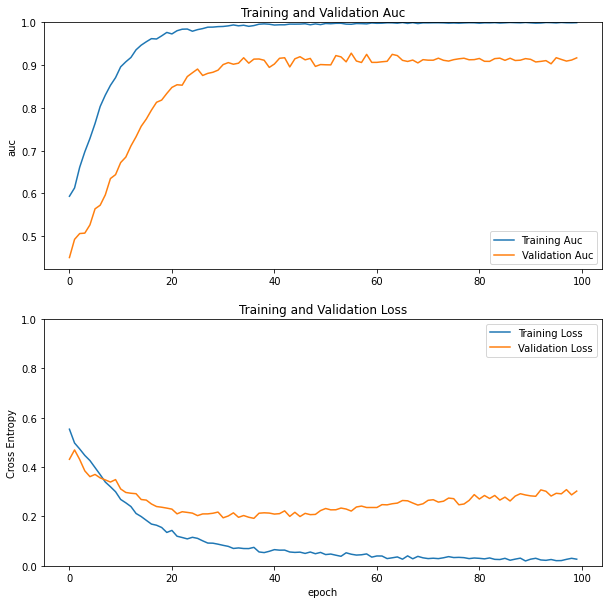

auc= 0.95


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       741
           1       0.98      0.89      0.93       141

    accuracy                           0.98       882
   macro avg       0.98      0.94      0.96       882
weighted avg       0.98      0.98      0.98       882



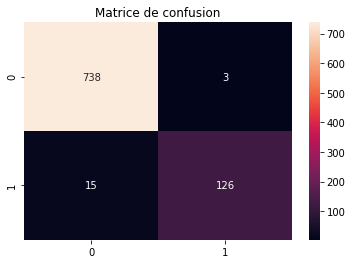

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_smote_tomek, y_train_smote_tomek , validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_smote_tomek, y_train_smote_tomek , validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 9. Conclusion

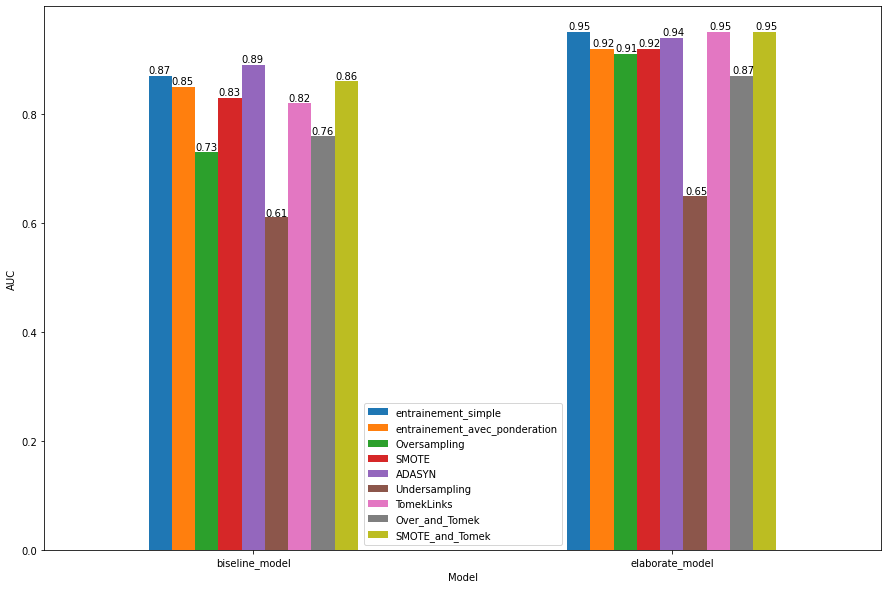

In [ ]:
# Définir les résultats de chaque méthodes
resultat = {
    "entrainement_simple": [0.87, 0.95],
    "entrainement_avec_ponderation":[0.85, 0.92],
    "Oversampling": [0.73, 0.91],
    "SMOTE": [0.83, 0.92],
    "ADASYN": [0.89, 0.94],
    "Undersampling": [0.61, 0.65],
    "TomekLinks": [0.82, 0.95],
    "Over_and_Tomek": [0.76, 0.87],
    "SMOTE_and_Tomek": [0.86, 0.95] 
            }

resultat = pd.DataFrame(resultat, index=["biseline_model", "elaborate_model"])

# Afficher les résultats
ax = resultat.plot(kind='bar', figsize=(15, 10), rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.set_xlabel("Model")
ax.set_ylabel("AUC")
plt.show()


le meilleur résultat est 95% (AUC), trouvé en utilisant l'approche simple (sans l'utilisation de poids), et la méthode hybride SMOTE + TomekLinks.

Ici, la méthode simple a bien fonctionné car l'estimation des hyperparamètres a été faite sur les données déséquilibrées.


Les résultats peuvent être améliorés en essayant d'estimer le nombre d'observations à ajouter avec la méthode SMOTE par exemple, ou le nombre d'observations à supprimer...ect

Il existe d'autres méthodes qui peuvent donner de bons résultats, par exemple, effectuer un clustering sur les données de la classe majoritaire puis calculer la moyenne des observations de chaque cluster, ici le nombre de clusters doit correspondre au nombre d'observations que l'on veulent extraire de la classe majoritaire.